In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [ ]:
class EmailToneDataset(Dataset):
    def __init__(self, filepath, tokenizer, max_len=100):
        self.data = pd.read_csv(filepath)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        informal = "Informal: " + self.data.iloc[index]['Informal']
        formal = self.data.iloc[index]['Formal']

        source = self.tokenizer(informal, padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt")
        target = self.tokenizer(formal, padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt")

        return {
            'input_ids': source['input_ids'].squeeze(),
            'attention_mask': source['attention_mask'].squeeze(),
            'labels': target['input_ids'].squeeze()
        }


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base").to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# train_dataset = EmailToneDataset(filepath='nlpdf.csv', tokenizer=tokenizer)
# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

def train_epoch(model, dataloader):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    return total_loss / len(dataloader)




In [ ]:
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("nlpdf.csv")

# Split: 80% train, 10% val, 10% test
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False)


In [ ]:
train_dataset = EmailToneDataset("train.csv", tokenizer)
val_dataset = EmailToneDataset("val.csv", tokenizer)
test_dataset = EmailToneDataset("test.csv", tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)


In [ ]:
def evaluate_loss(model, dataloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
    return total_loss / len(dataloader)


In [ ]:
import os
import matplotlib.pyplot as plt

Epoch 1 | Train Loss: 0.0009 | Val Loss: 0.0061
Epoch 2 | Train Loss: 0.0011 | Val Loss: 0.0070
Epoch 3 | Train Loss: 0.0009 | Val Loss: 0.0063
Epoch 4 | Train Loss: 0.0006 | Val Loss: 0.0065
Epoch 5 | Train Loss: 0.0006 | Val Loss: 0.0065
Epoch 6 | Train Loss: 0.0007 | Val Loss: 0.0067
Epoch 7 | Train Loss: 0.0005 | Val Loss: 0.0065
Epoch 8 | Train Loss: 0.0005 | Val Loss: 0.0067
Epoch 9 | Train Loss: 0.0005 | Val Loss: 0.0069
Epoch 10 | Train Loss: 0.0007 | Val Loss: 0.0069


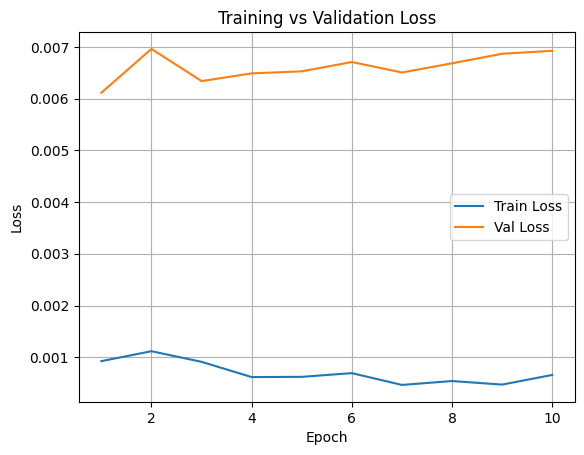

In [ ]:
train_losses = []
val_losses = []

for epoch in range(10):  # or however many epochs you want
    train_loss = train_epoch(model, train_loader)
    val_loss = evaluate_loss(model, val_loader)

    train_losses.append({"epoch": epoch+1, "loss": train_loss})
    val_losses.append({"epoch": epoch+1, "loss": val_loss})

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


# Save to CSV
os.makedirs("outputs", exist_ok=True)
pd.DataFrame(train_losses).to_csv("outputs/train_loss.csv", index=False)
pd.DataFrame(val_losses).to_csv("outputs/val_loss.csv", index=False)

# Plot both
plt.plot([d['epoch'] for d in train_losses], [d['loss'] for d in train_losses], label='Train Loss')
plt.plot([d['epoch'] for d in val_losses], [d['loss'] for d in val_losses], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("outputs/loss_comparison.png")
plt.show()


In [ ]:
model.save_pretrained("outputs/formal_rewriter_model_updated")
tokenizer.save_pretrained("outputs/formal_rewriter_model_updated")

('outputs/formal_rewriter_model_updated/tokenizer_config.json',
 'outputs/formal_rewriter_model_updated/special_tokens_map.json',
 'outputs/formal_rewriter_model_updated/spiece.model',
 'outputs/formal_rewriter_model_updated/added_tokens.json')

In [ ]:
def rewrite_email(text):
    input_text = "informal: " + text
    inputs = tokenizer(input_text, return_tensors="pt", padding=True).to(device)
    outputs = model.generate(**inputs, max_length=100)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example
informal_text = "How are u"
print("Formal:", rewrite_email(informal_text))


Formal: How are you


In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=f1050f3341b84d754be74695803b85ebd720f3ed0b066877127b50689ae27f11
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

nltk.download('punkt')

smooth = SmoothingFunction().method4
rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def evaluate_model(model, tokenizer, dataset, num_samples=100):
    model.eval()

    bleu_scores = []
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []

    with torch.no_grad():
        for i in range(min(num_samples, len(dataset))):
            sample = dataset[i]
            input_ids = sample['input_ids'].unsqueeze(0).to(device)
            attention_mask = sample['attention_mask'].unsqueeze(0).to(device)

            output = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=100)
            generated = tokenizer.decode(output[0], skip_special_tokens=True)

            reference = tokenizer.decode(sample['labels'], skip_special_tokens=True)

            # BLEU
            ref_tokens = nltk.word_tokenize(reference)
            gen_tokens = nltk.word_tokenize(generated)
            bleu = sentence_bleu([ref_tokens], gen_tokens, smoothing_function=smooth)
            bleu_scores.append(bleu)

            # ROUGE
            scores = rouge.score(generated, reference)
            rouge1_scores.append(scores['rouge1'].fmeasure)
            rouge2_scores.append(scores['rouge2'].fmeasure)
            rougeL_scores.append(scores['rougeL'].fmeasure)

    print(f"BLEU Score: {sum(bleu_scores) / len(bleu_scores):.4f}")
    print(f"ROUGE-1: {sum(rouge1_scores) / len(rouge1_scores):.4f}")
    print(f"ROUGE-2: {sum(rouge2_scores) / len(rouge2_scores):.4f}")
    print(f"ROUGE-L: {sum(rougeL_scores) / len(rougeL_scores):.4f}")


In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# model_path = "outputs/formal_rewriter_model"
model_path = "outputs/formal_rewriter_model_updated"
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path).to(device)

model.eval()  # Set to eval mode

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [ ]:
import nltk

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
evaluate_model(model, tokenizer, test_dataset, num_samples=100)


BLEU Score: 0.9576
ROUGE-1: 0.9789
ROUGE-2: 0.9703
ROUGE-L: 0.9789
